In [ ]:
import tensorflow
from tensorflow.keras.datasets.mnist import load_data

(trainX,trainY), (testX,testY) = load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# define standalone discriminator
def define_discriminator(input_shape=(28,28,1),n_classes=10):
  # label input
  in_labels = Input(shape=(1,))
  # Embedding for categorical input
  em = Embedding(n_classes,50)(in_labels)
  # scale up the image dimension with linear activations
  d1 = Dense(input_shape[0] * input_shape[1])(em)
  # reshape to additional channel
  d1 = Reshape((input_shape[0],input_shape[1],1))(d1)

  # image input
  image_input = Input(shape=input_shape)
  # concate label as channel
  merge = Concatenate()([image_input,d1])
  
  # downsample
  fe = Conv2D(128,(3,3),strides=(2,2),padding='same')(merge)
  fe = LeakyReLU(0.2)(fe)

  # downsample
  fe = Conv2D(128,(3,3),strides=(2,2),padding='same')(merge)
  fe = LeakyReLU(0.2)(fe)

  #flatten feature maps
  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)
  #ouput 
  out_layer = Dense(1,activation='sigmoid')(fe)
  #define model
  model = Model([image_input,in_labels],out_layer)
  #compile model
  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import array
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
import numpy as np

In [ ]:
disc_model = define_discriminator()



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


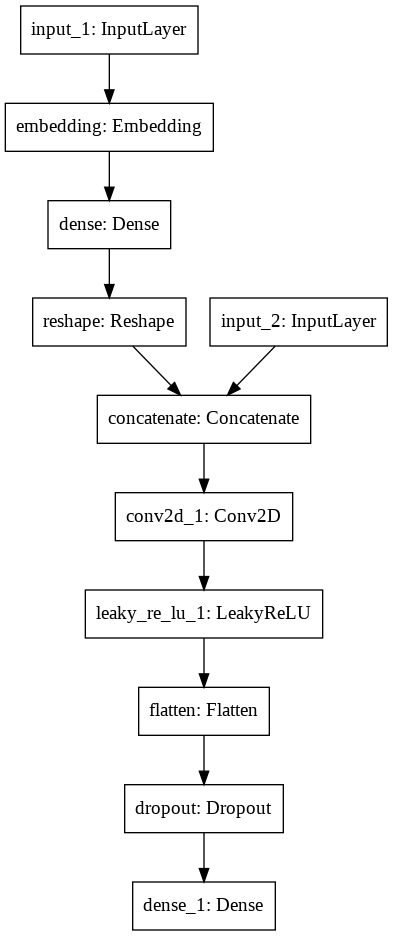

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(disc_model, to_file='LanguageModellingGraph.png')

In [ ]:
disc_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500         input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________________

In [ ]:
# define standalone generator model
def define_generator(latent_dim,n_classes=10):
  label_input = Input(shape=(1,))
  #Embedding layer
  em = Embedding(n_classes,50)(label_input)
  
  nodes = 7*7
  em = Dense(nodes)(em)
  em = Reshape((7,7,1))(em)

  #image generator input 
  image_input = Input(shape=(latent_dim,))
  nodes = 128*7*7
  d1 = Dense(nodes)(image_input)
  d1 = LeakyReLU(0.2)(d1)
  d1 = Reshape((7,7,128))(d1)

  # merge
  merge = Concatenate()([d1,em])

  #psample to 14x14
  gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(merge)
  gen = LeakyReLU(0.2)(gen)

  #upsample to 28x28
  gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(gen)
  gen = LeakyReLU(0.2)(gen)

  #output layer
  out_layer = Conv2D(1,(7,7),activation='tanh',padding='same')(gen)

  #define model
  model = Model([image_input,label_input],out_layer)
  return model

In [ ]:
gen_model = define_generator(100)
gen_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 6272)         633472      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_5[0][0]                    
____________________________________________________________________________________________

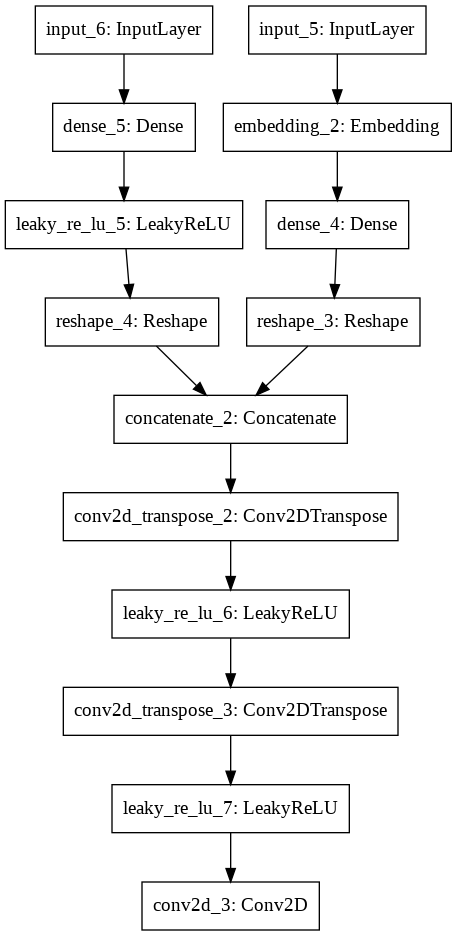

In [ ]:
plot_model(gen_model, to_file='LanguageModellingGraph.png')

In [ ]:
# defining the combined generator and discriminator model for updating the generator
def define_gan(g_model,d_model):
  # make the discriminator layer as non trainable
  d_model.trainable = False

  # get the noise and label input from the generator
  gen_noise, gen_label = g_model.input

  # get the output from the generator 
  gen_output = g_model.output

  #connect image output and label input from generator as inputs to discriminator
  gan_output = d_model([gen_output,gen_label])

  #define gan model as taking noise and label and outputting a classification
  model = Model([gen_noise,gen_label],gan_output)

  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

In [ ]:
gan_model = define_gan(gen_model,disc_model)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


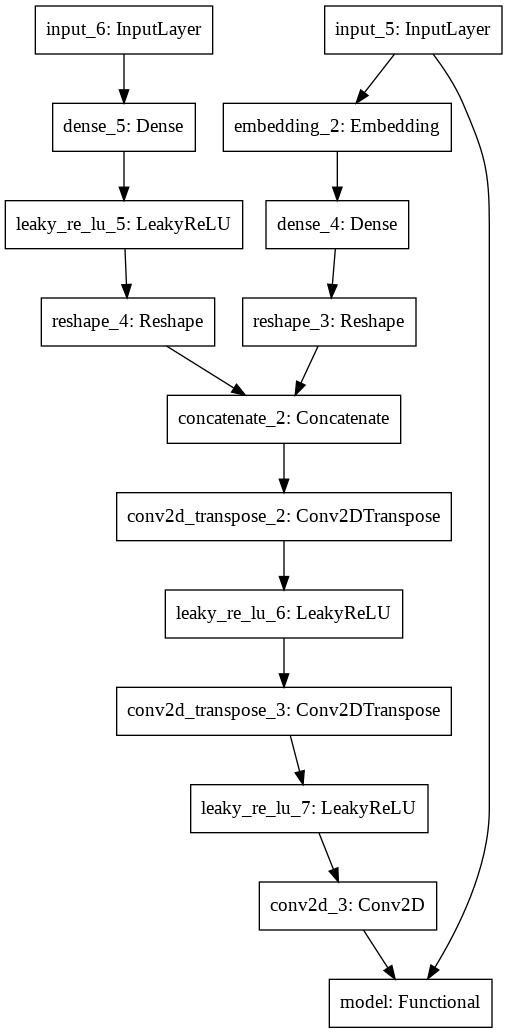

In [ ]:
plot_model(gan_model, to_file='LanguageModellingGraph.png')

In [ ]:
import tensorflow
from tensorflow.keras.datasets.mnist import load_data

In [ ]:
(trainX,trainY),(testX,testY) = load_data()

In [ ]:
print(trainX.shape)

(60000, 28, 28)


In [ ]:
print(trainX[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [ ]:
# load mnsit images
def load_real_samples():
  (trainX,trainY),(testX,testY) = load_data()

  # expand to 3d 
  X = expand_dims(trainX,axis=-1)
  #make it float
  X = X.astype('float32')
  # scale from [0,255] tp [-1,1]
  X = (X - 127.5) / 127.5

  return [X,trainY]

In [ ]:
# select real samples
def generate_real_samples(dataset,n_samples):
  # split into images and labels
  images,labels = dataset
  #choose random instances
  ix = randint(0,images.shape[0],n_samples)
  # select images and labels
  X, Labels = images[ix], labels[ix]
  # generate class labels
  y = ones((n_samples,1))
  return [X,Labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(laten_dim,n_samples,n_classes=10):
  # generate points in the latent space 
  x_input = randn(latent_dim*n_samples)
  # reshape into a batch of inputs to the network
  z_input = x_input.reshape(n_samples,latent_dim)
  # generate labels
  labels = randint(0,n_classes,n_samples)
  return [z_input,labels]

In [ ]:
# use generator to generate n fake samples, with class labels
def generate_fake_samples(latent_dim,n_samples,generator):
  #generate points in latent space
  z_input,labels = generate_latent_points(latent_dim,n_samples)
  #predict outputs
  images = generator.predict([z_input,labels])

  # create class labels
  y = zeros((n_samples,1))
  return [np.array(images),labels],y

In [ ]:
def save_plot(examples,epoch,n=10):
  for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0],cmap='gray_r')
  # save plot to file
  filename = 'generated_plot_e%03d.png' % (epoch+1)

  plt.savefig(filename)
  plt.close()

In [ ]:
def summarize_perf(gen_model,latent_dim,epoch):
  [images,labels] = generate_fake_samples(latent_dim,100,gen_model)
  
  save_plot(images,epoch)

  

In [ ]:
def train_gan(gen_model,disc_model,gan_model,latent_dim,dataset,n_epochs=100,n_batches=128):
  batches_per_epoch = int(dataset[0].shape[0]/n_batches)
  half_batch = int(n_batches/2)
  for i in range(n_epochs):
    print('epoch ',i)
    for j in range(batches_per_epoch):

      #generate real samples
      [X_real,labels_real], y_real = generate_real_samples(dataset,half_batch)
      
      #generate fake samples
      [X_fake,labels_fake], y_fake = generate_fake_samples(latent_dim,half_batch,gen_model)

      # train the discriminator on real and fake samples
      loss_real,acc_real = disc_model.train_on_batch([X_real,labels_real],y_real)

      loss_fake,acc_fake = disc_model.train_on_batch([X_fake,labels_fake],y_fake)

      # prepare points in the latent space as input to the generator
      [z_input,labels_input] = generate_latent_points(latent_dim,n_batches)
      # create inverted labels for fake samples
      y_gan = ones((n_batches,1))
      #update the generator model via the discriminator
      g_loss = gan_model.train_on_batch([z_input,labels_input],y_gan)

    

    if ((i+1)%10) == 0:
      gen_model.save('c_gan%3d.h5'%i)





In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import array
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
import numpy as np

In [ ]:
# size of the latent dimensions
latent_dim = 100
#discriminator model
discriminator = define_discriminator()
#generator model
generator = define_generator(latent_dim)
#create the gan model
gan = define_gan(generator,discriminator)
#dataset
dataset = load_real_samples()
#train model
train_gan(generator,discriminator,gan,latent_dim,dataset)

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39
epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49
epoch  50
epoch  51
epoch  52
epoch  53
epoch  54
epoch  55
epoch  56
epoch  57
epoch  58
epoch  59
epoch  60
epoch  61
epoch  62
epoch  63
epoch  64
epoch  65
epoch  66
epoch  67
epoch  68
epoch  69
epoch  70
epoch  71
epoch  72
epoch  73
epoch  74
epoch  75
epoch  76
epoch  77
epoch  78
epoch  79
epoch  80
epoch  81
epoch  82
epoch  83


KeyboardInterrupt: ignored

In [ ]:
generator.input

In [ ]:
generator.output

In [ ]:
def save_plot(X,n):
  for i in range(n*n):
    plt.axis('off')
    plt.subplot(n,n,i+1)
    plt.imshow(X[i,:,:,0],cmap='gray_r')
  plt.show()


In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import matplotlib.pyplot as plt

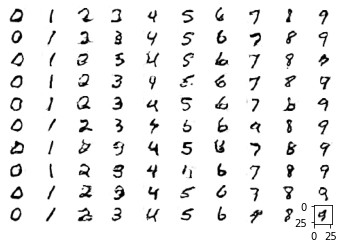

In [ ]:
model = load_model('/content/drive/MyDrive/conditional_gans_epoch_70.h5')

# latent_dim
latent_dim = 100
[inputs,labels] = generate_latent_points(latent_dim,100)

labels = np.asarray([x for _ in range(10) for x in range(10)])

X = model.predict([inputs,labels])

#X = (X + 1)/2.0 
save_plot(X,10)

In [ ]:
latent_dim = 100
[inputs,labels] = generate_latent_points(latent_dim,100)
print(labels)

[4 9 3 9 4 3 4 9 4 4 4 7 2 3 7 2 5 1 2 4 5 0 3 4 3 1 2 9 6 4 7 4 0 6 7 9 9
 5 7 3 6 1 1 6 0 6 0 9 8 2 1 4 9 3 8 8 0 8 4 1 9 0 4 0 4 1 2 7 9 6 3 1 3 2
 9 8 1 0 1 5 9 3 7 4 7 0 6 9 4 7 9 1 7 5 3 8 1 4 4 9]


In [ ]:
import numpy as np
labels = np.asarray([x for _ in range(10) for x in range(10)])
print(labels)

[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
